# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

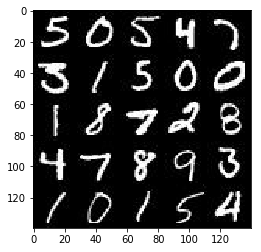

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

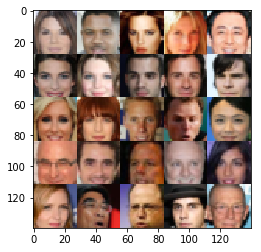

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    training = True
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.maximum(alpha * x, x)
        x = tf.layers.dropout(x, 0.8)
        
        x = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.dropout(x, 0.8)
        
        x = tf.layers.conv2d(images, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.dropout(x, 0.8)
        
        # x = tf.layers.conv2d(images, 512, 5, strides=2, padding='same')
        # x = tf.layers.batch_normalization(x, training=training)
        # x = tf.maximum(alpha * x, x)
        # x = tf.layers.dropout(x, 0.3)
        
        logits = tf.layers.dense(tf.reshape(x, (-1, 7 * 7 * 256)), 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """        
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7 * 7 * 256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # x = tf.nn.relu(x)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # x = tf.nn.relu(x)
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # x = tf.nn.relu(x)
        # 14 x 14 x 128
        
        x = tf.layers.conv2d_transpose(x, 32, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 28 x 28 x 64

        x = tf.layers.conv2d_transpose(x, 16, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28 x 28 x out_channel_dim
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_output = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    
    d_output_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                      logits=d_logits_real,
                      labels=tf.ones_like(d_output_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                      logits=d_logits_fake,
                      labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_logits_fake,
                    labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    show_every = 500
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=0.2, smooth=0.1)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                batch_images = batch_images * 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                if step % (show_every // 10) == 0:
                    train_loss_d = d_loss.eval({input_real:batch_images,
                                                input_z: batch_z,
                                                lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch %2d/%2d d_loss: %.4f g_loss %.4f" 
                          % (epoch_i + 1, epoch_count, train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch  1/ 2 d_loss: 1.4543 g_loss 0.6842
Epoch  1/ 2 d_loss: 1.4267 g_loss 0.8128
Epoch  1/ 2 d_loss: 1.5246 g_loss 0.7537
Epoch  1/ 2 d_loss: 1.4341 g_loss 0.6171
Epoch  1/ 2 d_loss: 1.4827 g_loss 0.5845
Epoch  1/ 2 d_loss: 1.4295 g_loss 0.7385
Epoch  1/ 2 d_loss: 1.3806 g_loss 0.7920
Epoch  1/ 2 d_loss: 1.3967 g_loss 0.9429
Epoch  1/ 2 d_loss: 1.3999 g_loss 0.7555
Epoch  1/ 2 d_loss: 1.3919 g_loss 0.8773


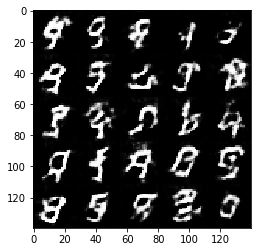

Epoch  1/ 2 d_loss: 1.4058 g_loss 0.6591
Epoch  1/ 2 d_loss: 1.3646 g_loss 1.0854
Epoch  1/ 2 d_loss: 1.4147 g_loss 0.6069
Epoch  1/ 2 d_loss: 1.3790 g_loss 0.8298
Epoch  1/ 2 d_loss: 1.4026 g_loss 0.8344
Epoch  1/ 2 d_loss: 1.3955 g_loss 0.9264
Epoch  1/ 2 d_loss: 1.3768 g_loss 0.7710
Epoch  1/ 2 d_loss: 1.3791 g_loss 0.9474
Epoch  1/ 2 d_loss: 1.4252 g_loss 1.0286
Epoch  1/ 2 d_loss: 1.4568 g_loss 1.1202


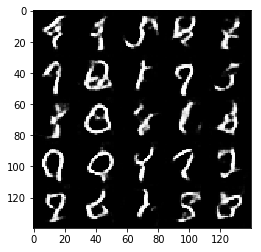

Epoch  1/ 2 d_loss: 1.4053 g_loss 0.6257
Epoch  1/ 2 d_loss: 1.3568 g_loss 0.7940
Epoch  1/ 2 d_loss: 1.4007 g_loss 0.7309
Epoch  1/ 2 d_loss: 1.4016 g_loss 0.7423
Epoch  1/ 2 d_loss: 1.4268 g_loss 0.7344
Epoch  1/ 2 d_loss: 1.4101 g_loss 0.6467
Epoch  1/ 2 d_loss: 1.3852 g_loss 0.6853
Epoch  1/ 2 d_loss: 1.4228 g_loss 0.8400
Epoch  1/ 2 d_loss: 1.4256 g_loss 0.9774
Epoch  1/ 2 d_loss: 1.4119 g_loss 0.6943


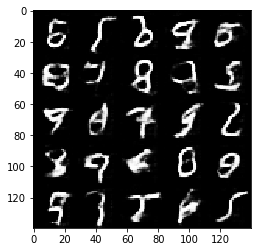

Epoch  1/ 2 d_loss: 1.4444 g_loss 0.6079
Epoch  1/ 2 d_loss: 1.4015 g_loss 1.0023
Epoch  1/ 2 d_loss: 1.3638 g_loss 0.8550
Epoch  1/ 2 d_loss: 1.4047 g_loss 0.7814
Epoch  1/ 2 d_loss: 1.3936 g_loss 0.8814
Epoch  1/ 2 d_loss: 1.3896 g_loss 0.6990
Epoch  1/ 2 d_loss: 1.4071 g_loss 0.8758
Epoch  2/ 2 d_loss: 1.3930 g_loss 0.6388
Epoch  2/ 2 d_loss: 1.3947 g_loss 0.8159
Epoch  2/ 2 d_loss: 1.4111 g_loss 0.9125


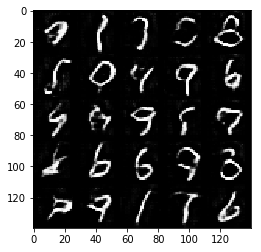

Epoch  2/ 2 d_loss: 1.3693 g_loss 0.8148
Epoch  2/ 2 d_loss: 1.3855 g_loss 0.8663
Epoch  2/ 2 d_loss: 1.3859 g_loss 0.6440
Epoch  2/ 2 d_loss: 1.3790 g_loss 0.8170
Epoch  2/ 2 d_loss: 1.4114 g_loss 0.6243
Epoch  2/ 2 d_loss: 1.3969 g_loss 0.9373
Epoch  2/ 2 d_loss: 1.3827 g_loss 0.8360
Epoch  2/ 2 d_loss: 1.4157 g_loss 0.6992
Epoch  2/ 2 d_loss: 1.3952 g_loss 0.7744
Epoch  2/ 2 d_loss: 1.3906 g_loss 0.6835


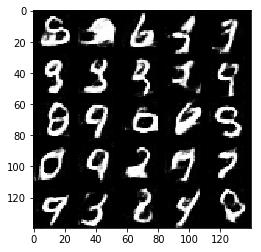

Epoch  2/ 2 d_loss: 1.3864 g_loss 0.9316
Epoch  2/ 2 d_loss: 1.3763 g_loss 0.8267
Epoch  2/ 2 d_loss: 1.4007 g_loss 0.8930
Epoch  2/ 2 d_loss: 1.4028 g_loss 1.0265
Epoch  2/ 2 d_loss: 1.3883 g_loss 0.7744
Epoch  2/ 2 d_loss: 1.3952 g_loss 0.8767
Epoch  2/ 2 d_loss: 1.4076 g_loss 0.7148
Epoch  2/ 2 d_loss: 1.4032 g_loss 0.6779
Epoch  2/ 2 d_loss: 1.3876 g_loss 0.7709
Epoch  2/ 2 d_loss: 1.4080 g_loss 0.6665


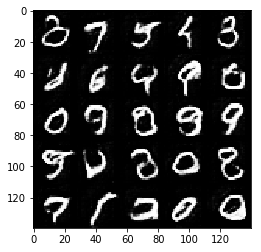

Epoch  2/ 2 d_loss: 1.3698 g_loss 0.9913
Epoch  2/ 2 d_loss: 1.3774 g_loss 0.7519
Epoch  2/ 2 d_loss: 1.3718 g_loss 0.8917
Epoch  2/ 2 d_loss: 1.3819 g_loss 0.8154
Epoch  2/ 2 d_loss: 1.3676 g_loss 0.8248
Epoch  2/ 2 d_loss: 1.3677 g_loss 0.7894
Epoch  2/ 2 d_loss: 1.3968 g_loss 0.6591
Epoch  2/ 2 d_loss: 1.3482 g_loss 0.9553
Epoch  2/ 2 d_loss: 1.3736 g_loss 0.7961
Epoch  2/ 2 d_loss: 1.4239 g_loss 1.1482


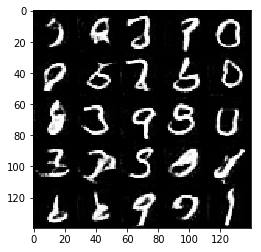

Epoch  2/ 2 d_loss: 1.4016 g_loss 0.7532
Epoch  2/ 2 d_loss: 1.3933 g_loss 0.7611
Epoch  2/ 2 d_loss: 1.3660 g_loss 0.8601
Epoch  2/ 2 d_loss: 1.3921 g_loss 0.6609
Epoch  2/ 2 d_loss: 1.3782 g_loss 0.9260


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch  1/ 1 d_loss: 1.1332 g_loss 1.1166
Epoch  1/ 1 d_loss: 1.0206 g_loss 1.0553
Epoch  1/ 1 d_loss: 1.2420 g_loss 1.0502
Epoch  1/ 1 d_loss: 0.9451 g_loss 1.7163
Epoch  1/ 1 d_loss: 1.0784 g_loss 1.2961
Epoch  1/ 1 d_loss: 1.2827 g_loss 0.7103
Epoch  1/ 1 d_loss: 1.0789 g_loss 0.9271
Epoch  1/ 1 d_loss: 1.5401 g_loss 1.1799
Epoch  1/ 1 d_loss: 1.5031 g_loss 0.6950
Epoch  1/ 1 d_loss: 1.4195 g_loss 0.8125


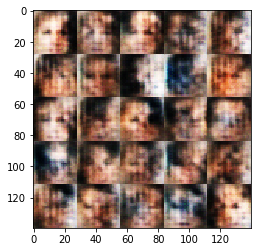

Epoch  1/ 1 d_loss: 1.3125 g_loss 0.7783
Epoch  1/ 1 d_loss: 1.4014 g_loss 0.7835
Epoch  1/ 1 d_loss: 1.3537 g_loss 0.7811
Epoch  1/ 1 d_loss: 1.4848 g_loss 0.6681
Epoch  1/ 1 d_loss: 1.3540 g_loss 1.0515
Epoch  1/ 1 d_loss: 1.2148 g_loss 0.9909
Epoch  1/ 1 d_loss: 1.3971 g_loss 0.5795
Epoch  1/ 1 d_loss: 1.2942 g_loss 1.1149
Epoch  1/ 1 d_loss: 1.7567 g_loss 0.6840
Epoch  1/ 1 d_loss: 1.3166 g_loss 0.8906


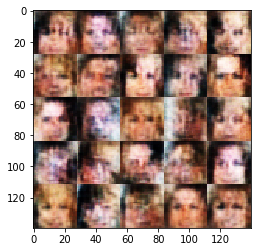

Epoch  1/ 1 d_loss: 1.2593 g_loss 1.0924
Epoch  1/ 1 d_loss: 1.3043 g_loss 0.8208
Epoch  1/ 1 d_loss: 1.2641 g_loss 0.8555
Epoch  1/ 1 d_loss: 1.3952 g_loss 0.7432
Epoch  1/ 1 d_loss: 1.3749 g_loss 0.7951
Epoch  1/ 1 d_loss: 1.3704 g_loss 0.8103
Epoch  1/ 1 d_loss: 1.3995 g_loss 0.8000
Epoch  1/ 1 d_loss: 1.4241 g_loss 0.6812
Epoch  1/ 1 d_loss: 1.3457 g_loss 0.8084
Epoch  1/ 1 d_loss: 1.4435 g_loss 0.9044


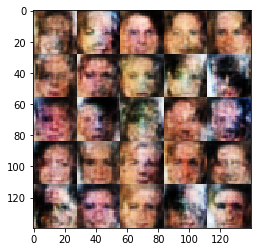

Epoch  1/ 1 d_loss: 1.4617 g_loss 0.6899
Epoch  1/ 1 d_loss: 1.3839 g_loss 0.8459
Epoch  1/ 1 d_loss: 1.3465 g_loss 0.9884
Epoch  1/ 1 d_loss: 1.3953 g_loss 0.7104
Epoch  1/ 1 d_loss: 1.3698 g_loss 0.7644
Epoch  1/ 1 d_loss: 1.4641 g_loss 0.7857
Epoch  1/ 1 d_loss: 1.3781 g_loss 0.7621
Epoch  1/ 1 d_loss: 1.4340 g_loss 0.9445
Epoch  1/ 1 d_loss: 1.4296 g_loss 0.7671
Epoch  1/ 1 d_loss: 1.4171 g_loss 0.7237


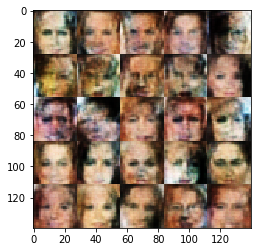

Epoch  1/ 1 d_loss: 1.4262 g_loss 0.5816
Epoch  1/ 1 d_loss: 1.4737 g_loss 0.7925
Epoch  1/ 1 d_loss: 1.4266 g_loss 0.7853
Epoch  1/ 1 d_loss: 1.4167 g_loss 0.9003
Epoch  1/ 1 d_loss: 1.4580 g_loss 0.7768
Epoch  1/ 1 d_loss: 1.4311 g_loss 0.7787
Epoch  1/ 1 d_loss: 1.4028 g_loss 0.8505
Epoch  1/ 1 d_loss: 1.4215 g_loss 0.8410
Epoch  1/ 1 d_loss: 1.4214 g_loss 0.7337
Epoch  1/ 1 d_loss: 1.3721 g_loss 0.8926


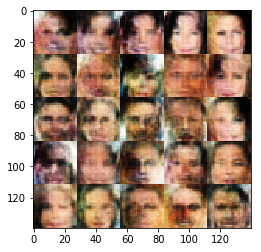

Epoch  1/ 1 d_loss: 1.3606 g_loss 0.7814
Epoch  1/ 1 d_loss: 1.3788 g_loss 0.7160
Epoch  1/ 1 d_loss: 1.4067 g_loss 0.8343
Epoch  1/ 1 d_loss: 1.4547 g_loss 0.7724
Epoch  1/ 1 d_loss: 1.3926 g_loss 0.8624
Epoch  1/ 1 d_loss: 1.3973 g_loss 0.7211
Epoch  1/ 1 d_loss: 1.3717 g_loss 0.8249
Epoch  1/ 1 d_loss: 1.4189 g_loss 0.8096
Epoch  1/ 1 d_loss: 1.3840 g_loss 0.7956
Epoch  1/ 1 d_loss: 1.4428 g_loss 0.7311


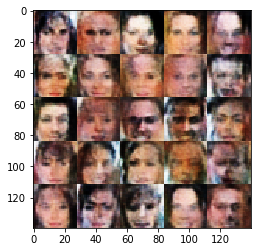

Epoch  1/ 1 d_loss: 1.4303 g_loss 0.9185
Epoch  1/ 1 d_loss: 1.4485 g_loss 0.8450
Epoch  1/ 1 d_loss: 1.3808 g_loss 0.7521
Epoch  1/ 1 d_loss: 1.4060 g_loss 0.7502
Epoch  1/ 1 d_loss: 1.4938 g_loss 0.5518
Epoch  1/ 1 d_loss: 1.4187 g_loss 0.7841
Epoch  1/ 1 d_loss: 1.3813 g_loss 0.6776
Epoch  1/ 1 d_loss: 1.4168 g_loss 0.8944
Epoch  1/ 1 d_loss: 1.4206 g_loss 0.8087
Epoch  1/ 1 d_loss: 1.4816 g_loss 0.7776


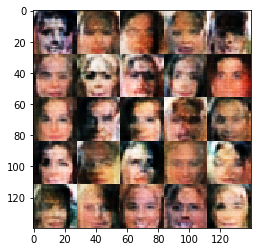

Epoch  1/ 1 d_loss: 1.4495 g_loss 0.7121
Epoch  1/ 1 d_loss: 1.4040 g_loss 0.9484
Epoch  1/ 1 d_loss: 1.3594 g_loss 0.8303
Epoch  1/ 1 d_loss: 1.4457 g_loss 0.8376
Epoch  1/ 1 d_loss: 1.4177 g_loss 0.7832
Epoch  1/ 1 d_loss: 1.4304 g_loss 0.8094
Epoch  1/ 1 d_loss: 1.4295 g_loss 0.9426
Epoch  1/ 1 d_loss: 1.3801 g_loss 0.7756
Epoch  1/ 1 d_loss: 1.3403 g_loss 0.8100
Epoch  1/ 1 d_loss: 1.4309 g_loss 0.9074


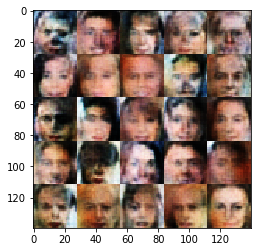

Epoch  1/ 1 d_loss: 1.3848 g_loss 0.7247
Epoch  1/ 1 d_loss: 1.3800 g_loss 0.8986
Epoch  1/ 1 d_loss: 1.4278 g_loss 0.7091
Epoch  1/ 1 d_loss: 1.3356 g_loss 0.8557
Epoch  1/ 1 d_loss: 1.3824 g_loss 0.7748
Epoch  1/ 1 d_loss: 1.4300 g_loss 0.7292
Epoch  1/ 1 d_loss: 1.4056 g_loss 0.8037
Epoch  1/ 1 d_loss: 1.4077 g_loss 0.7876
Epoch  1/ 1 d_loss: 1.3820 g_loss 0.8870
Epoch  1/ 1 d_loss: 1.4129 g_loss 0.7781


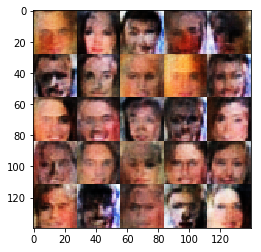

Epoch  1/ 1 d_loss: 1.4351 g_loss 0.8472
Epoch  1/ 1 d_loss: 1.3733 g_loss 0.8419
Epoch  1/ 1 d_loss: 1.4523 g_loss 0.6873
Epoch  1/ 1 d_loss: 1.4219 g_loss 0.7833
Epoch  1/ 1 d_loss: 1.5095 g_loss 0.6700
Epoch  1/ 1 d_loss: 1.4456 g_loss 0.7134
Epoch  1/ 1 d_loss: 1.3929 g_loss 0.8328
Epoch  1/ 1 d_loss: 1.3841 g_loss 0.7864
Epoch  1/ 1 d_loss: 1.3604 g_loss 0.8368
Epoch  1/ 1 d_loss: 1.4040 g_loss 0.7843


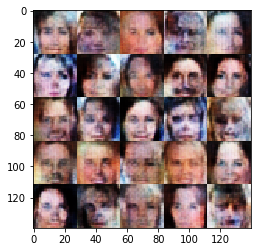

Epoch  1/ 1 d_loss: 1.4061 g_loss 0.8736
Epoch  1/ 1 d_loss: 1.4154 g_loss 0.7261
Epoch  1/ 1 d_loss: 1.3790 g_loss 0.8420
Epoch  1/ 1 d_loss: 1.3944 g_loss 0.8974
Epoch  1/ 1 d_loss: 1.4067 g_loss 0.7518
Epoch  1/ 1 d_loss: 1.4268 g_loss 0.7296
Epoch  1/ 1 d_loss: 1.4024 g_loss 0.8551
Epoch  1/ 1 d_loss: 1.4289 g_loss 0.7543
Epoch  1/ 1 d_loss: 1.4222 g_loss 0.6937
Epoch  1/ 1 d_loss: 1.4234 g_loss 0.8407


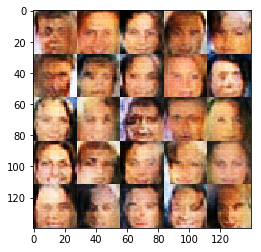

Epoch  1/ 1 d_loss: 1.3854 g_loss 0.8012
Epoch  1/ 1 d_loss: 1.4507 g_loss 0.7838
Epoch  1/ 1 d_loss: 1.5110 g_loss 0.6658
Epoch  1/ 1 d_loss: 1.3639 g_loss 0.7990
Epoch  1/ 1 d_loss: 1.4130 g_loss 0.7304
Epoch  1/ 1 d_loss: 1.4274 g_loss 0.7969
Epoch  1/ 1 d_loss: 1.3966 g_loss 0.8352
Epoch  1/ 1 d_loss: 1.4056 g_loss 0.7829
Epoch  1/ 1 d_loss: 1.4028 g_loss 0.7449
Epoch  1/ 1 d_loss: 1.4640 g_loss 0.8298


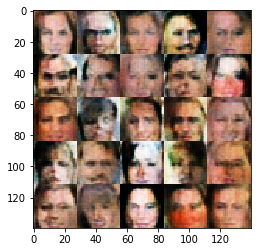

Epoch  1/ 1 d_loss: 1.3794 g_loss 0.7680
Epoch  1/ 1 d_loss: 1.4132 g_loss 0.7699
Epoch  1/ 1 d_loss: 1.4026 g_loss 0.8397
Epoch  1/ 1 d_loss: 1.4039 g_loss 0.8661
Epoch  1/ 1 d_loss: 1.4000 g_loss 0.7254
Epoch  1/ 1 d_loss: 1.4012 g_loss 0.7593


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.